In [1]:
#!/usr/bin/env python3

import os
import sys
import numpy as np 
import argparse 
import time 

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from tc.tc_fc import TTLinear 
from torchvision import datasets, transforms
from tt_VAEs import tt_autoencoder

seed = 7
np.random.seed(seed)
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_tensor = [7, 4, 7, 4]
hidden_tensors= [[8, 4, 8, 4], [8, 4, 8, 4], [4, 2, 4, 4]]
n_epochs = 5



In [31]:
if __name__=='__main__':


    ### get data
    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # load the training and test datasets
    train_data = datasets.MNIST(root='data', train=True,
                                       download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False,
                                      download=True, transform=transform)
    # Create training and test dataloaders

    # number of subprocesses to use for data loading
    num_workers = 0
    # how many samples per batch to load
    batch_size = 20

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
    tt_rank = [1, 2, 2, 2, 1]
    print('Building a Tensor-Train model...')
    model = tt_autoencoder(hidden_tensors, input_tensor, 10, tt_rank).to(device)
    
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    lr = 0.001
    # specify loss function
    criterion = nn.BCELoss()

    # specify loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    # number of epochs to train the model


Building a Tensor-Train model...
Model's state_dict:
encoder1.0.b 	 torch.Size([1])
encoder1.0.W_cores.0 	 torch.Size([1, 7, 8, 2])
encoder1.0.W_cores.1 	 torch.Size([2, 4, 4, 2])
encoder1.0.W_cores.2 	 torch.Size([2, 7, 8, 2])
encoder1.0.W_cores.3 	 torch.Size([2, 4, 4, 1])
encoder1.1.b 	 torch.Size([1])
encoder1.1.W_cores.0 	 torch.Size([1, 8, 8, 2])
encoder1.1.W_cores.1 	 torch.Size([2, 4, 4, 2])
encoder1.1.W_cores.2 	 torch.Size([2, 8, 8, 2])
encoder1.1.W_cores.3 	 torch.Size([2, 4, 4, 1])
encoder1.2.b 	 torch.Size([1])
encoder1.2.W_cores.0 	 torch.Size([1, 8, 4, 2])
encoder1.2.W_cores.1 	 torch.Size([2, 4, 2, 2])
encoder1.2.W_cores.2 	 torch.Size([2, 8, 4, 2])
encoder1.2.W_cores.3 	 torch.Size([2, 4, 4, 1])
decoder1.0.b 	 torch.Size([1])
decoder1.0.W_cores.0 	 torch.Size([1, 4, 8, 2])
decoder1.0.W_cores.1 	 torch.Size([2, 2, 4, 2])
decoder1.0.W_cores.2 	 torch.Size([2, 4, 8, 2])
decoder1.0.W_cores.3 	 torch.Size([2, 4, 4, 1])
decoder1.1.b 	 torch.Size([1])
decoder1.1.W_cores.0 	 t

In [32]:
n_epochs = 5
# model.load_state_dict(torch.load('ae_100_tt.pt'))

In [69]:
def train_ae(model, n_epochs, criterion, optimizer, use_Var = False):
#     print(model.model_name)
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            images, _ = data
            # flatten images
            images = images.view(images.size(0), -1)
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            if use_Var ==False:
                outputs = model(images)
                # calculate the loss
                loss = criterion(outputs, images)
            else:
                outputs, mu, log_var = model(images)
                loss = criterion(outputs, images, mu, log_var)
            
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss
            ))
    torch.save(model.state_dict(),"model_weights/"+ time.strftime("%m%d-%H%M")+ ".pt")
    return model, train_loss

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline


# obtain one batch of test images
def show_res(model, use_Var = False):
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
#     print(model.model_name)
    
    # get sample outputs
    if (use_Var == False):
        images_flatten = images.view(images.size(0), -1)
        output = model(images_flatten.to(device))
        # prep images for display
        images = images.numpy()
        # output is resized into a batch of images
        output = output.view(output.shape[0], 1, 28, 28)
        # use detach when it's an output that requires_grad
        output = output.cpu().detach().numpy()
    else:
        images_flatten = images.view(images.size(0), -1)
        _, (q_z, p_z), _, output = model(images_flatten)
        images = images.numpy()
        output = output.view(output.shape[0], 1, 28, 28)
        output = output.detach().numpy()



    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

Epoch: 1 	Training Loss: 2.176889
Epoch: 2 	Training Loss: 1.613509
Epoch: 3 	Training Loss: 1.540011
Epoch: 4 	Training Loss: 1.503072
Epoch: 5 	Training Loss: 1.478365
Tensor Train AE Results


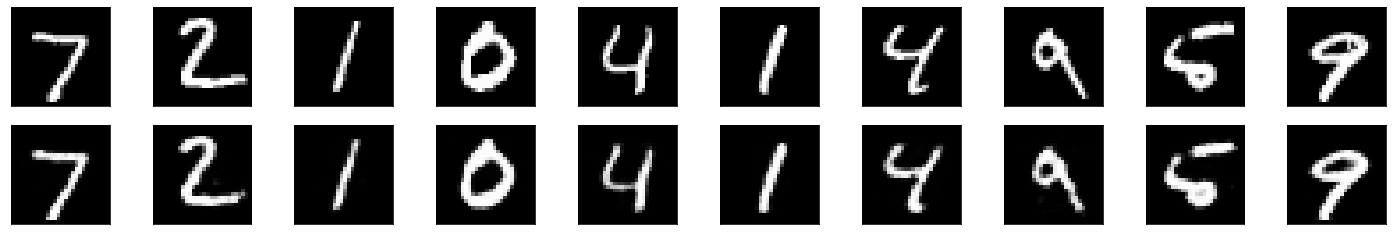

In [21]:
model = tt_autoencoder(hidden_tensors, input_tensor, 10, tt_rank).to(device)
criterion = nn.BCELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_ae, _ = train_ae(model, 5,criterion,optimizer)
print("Tensor Train AE Results")
show_res(model)

In [14]:
from dnn_VAEs import autoencoder
model_ae = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model_ae.parameters(), lr=1e-3, weight_decay=1e-5)

model_ae, _ = train_ae(model_ae, 5,criterion, optimizer)


Epoch: 1 	Training Loss: 1.001604
Epoch: 2 	Training Loss: 0.783190
Epoch: 3 	Training Loss: 0.741152
Epoch: 4 	Training Loss: 0.722330
Epoch: 5 	Training Loss: 0.710357


DNN AE Results


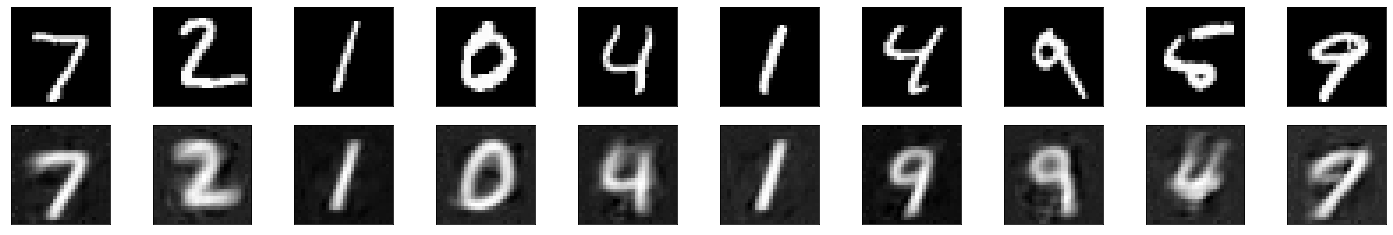

In [15]:
print("DNN AE Results")
show_res(model_ae)

In [93]:
class VAE_2(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE_2, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [95]:
model_VAE = VAE_2(x_dim = 784, h_dim1 = 512, h_dim2 = 256, z_dim = 2).cuda()

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# specify loss function
optimizer = torch.optim.Adam(model_VAE.parameters(), lr=0.001)
model_VAE, _ = train_ae(model_VAE, 5, loss_function, optimizer, use_Var = True)

Epoch: 1 	Training Loss: 66724.234098
Epoch: 2 	Training Loss: 61929.563818
Epoch: 3 	Training Loss: 60420.131134
Epoch: 4 	Training Loss: 59529.754115
Epoch: 5 	Training Loss: 59062.277990


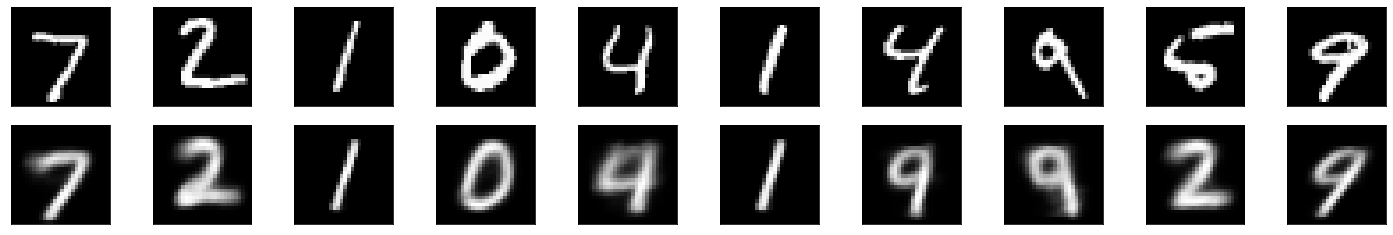

In [59]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
#     print(model.model_name)
images_flatten = images.view(images.size(0), -1)
output, mu, log_var = model_VAE(images_flatten.to(device))
# prep images for display
images = images.numpy()
# output is resized into a batch of images
output = output.view(output.shape[0], 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [90]:
class tt_VAE(nn.Module):
    def __init__(self, hidden_tensors, input_tensor, output_dim, tt_rank):
        super(tt_VAE, self).__init__()
        
        self.encoder1 = nn.Sequential(TTLinear(input_tensor, hidden_tensors[0], tt_rank=tt_rank),
                                      TTLinear(hidden_tensors[0], hidden_tensors[1], tt_rank=tt_rank))
        self.fc21 = TTLinear(hidden_tensors[1], hidden_tensors[2], tt_rank=tt_rank)
        self.fc22 = TTLinear(hidden_tensors[1], hidden_tensors[2], tt_rank=tt_rank)
        self.decoder1 = nn.Sequential(TTLinear(hidden_tensors[2],hidden_tensors[1], tt_rank=tt_rank),
                                      TTLinear(hidden_tensors[1],hidden_tensors[0], tt_rank=tt_rank),
                                      TTLinear(hidden_tensors[0],input_tensor, tt_rank=tt_rank))
        self.lin = nn.Linear(np.prod(input_tensor), np.prod(input_tensor))
        
    def encoder(self, x):
        out = self.encoder1(x)
        return self.fc21(out), self.fc22(out) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        out = F.sigmoid(self.lin(self.lin(self.decoder1(z))))
        return out
    
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

In [91]:
    
model_ttVAE = tt_VAE(hidden_tensors, input_tensor, 10, tt_rank).cuda()

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# specify loss function
optimizer = torch.optim.Adam(model_ttVAE.parameters(), lr=0.001)

model_ttVAE, _ = train_ae(model_ttVAE, 2, loss_function, optimizer, use_Var = True)



Epoch: 1 	Training Loss: 85132.989754
Epoch: 2 	Training Loss: 82651.735684
Epoch: 3 	Training Loss: 82601.174393
Epoch: 4 	Training Loss: 82554.686001
Epoch: 5 	Training Loss: 82513.999575


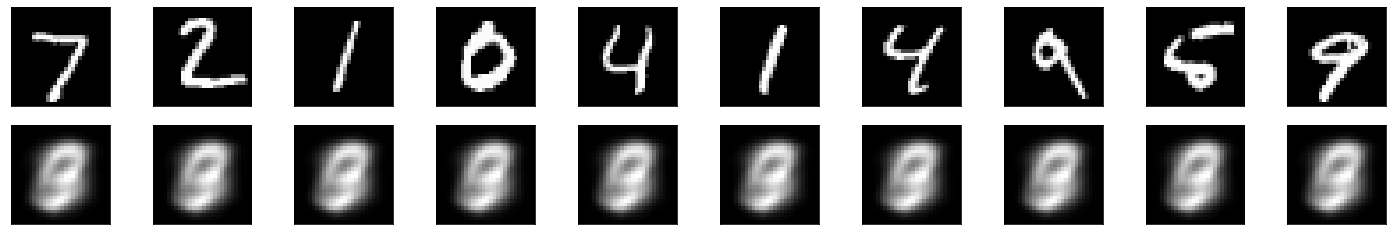

In [92]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
#     print(model.model_name)
images_flatten = images.view(images.size(0), -1)
output, mu, log_var = model_ttVAE(images_flatten.to(device))
# prep images for display
images = images.numpy()
# output is resized into a batch of images
output = output.view(output.shape[0], 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()


# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

